# Introduction

This report provides an overview of the Python package `scicomp` that was produced for this unit. The package provides functionality for solving non-stiff ordinary differential equations (ODEs), partial differential equations (PDEs), boundary value problems (BVPs), finding periodic orbits in ODEs using numerical shooting, and tracking steady state solutions and periodic orbits using numerical continuation. An overview of the design decisions taken and a reflective learning log are also presented.

# Demonstration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 16
plt.rc('text.latex', preamble=r"""\usepackage{amsmath} \usepackage{amssymb}
       \DeclareMathOperator*{\argmax}{arg\,max}""")

import scicomp

## Initial Value Problem (IVP) Solver

The foundation of the package is `scicomp.integrate.solve_ivp`. This provides functionality for finding the solution to IVPs. `solve_ivp` implements the following different explicit Runge-Kutta methods:

In [2]:
print(", ".join(scicomp.integrate._all_methods.keys()))

euler, midpoint, heun, ralston, kutta3, heun3, wray3, ralston3, ssprk3, rk4, rk38, ralston4, bogacki_shampine, rkf45, ck45, dopri45


Each of these methods can operate in two modes, either using a fixed timestep or an adaptive timestep, depending on the options specified by the user. In the adaptive timestep mode, the timestep is adjusted such that the estimated local error satisfies the user-specified absolute and relative tolerances. This is performed using the method described by Hairer and Wanner [1]. The estimate of the local error depends on the method used. Methods such as Runge-Kutta-Fehlberg and Dormand-Prince contain an embedded error estimate in their Butcher tableau. For methods without the embedded error estimate, such as Euler's method or the classic fourth order Runge-Kutta, the local error is estimated using Richardson extrapolation as described in [1]. The initial step size when using the adaptive timestep mode can either be specified by the user or selected automatically using the method described in [1].

To demonstrate the capabilities of the IVP solver we will consider the modified normal form of the Hopf bifurcation

\begin{align}
  \frac{\mathrm{d}u_1}{\mathrm{d}t} &= \beta u_1 - u_2 + u_1\left(u_1^2 + u_2^2\right) - u_1\left(u_1^2 + u_2^2\right)^2,\\
  \frac{\mathrm{d}u_2}{\mathrm{d}t} &= u_1 + \beta u_2 + u_2\left(u_1^2 + u_2^2\right) - u_2\left(u_1^2 + u_2^2\right)^2.
\end{align}

This ODE is provided as part of the pre-implemented ODEs in the `scicomp.odes` submodule. Below is a demonstration of solving this system of ODEs for $\beta=1$ with initial conditions $u_1(0)=1$ and $u_2(0)=-1$. The default solver, Runge-Kutta-Fehlberg, is used in adaptive mode (the default mode) with a relative tolerance of $1\mathrm{e}-6$.

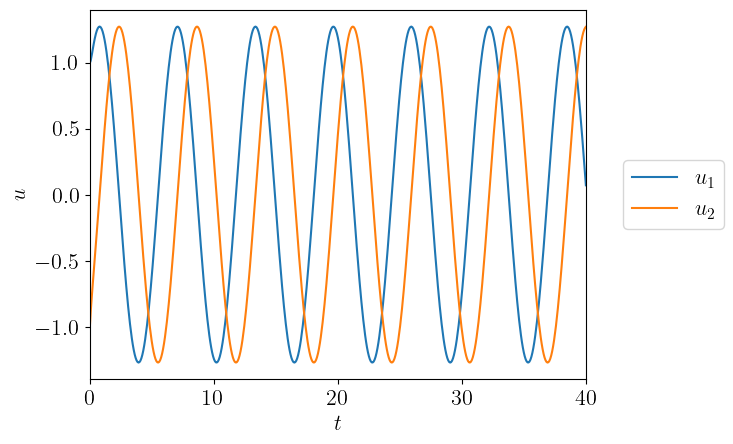

In [3]:
from scicomp.integrate import solve_ivp
from scicomp.odes import modified_hopf

ode_sol = solve_ivp(modified_hopf, y0=[1, -1], t_span=(0, 40),
                    ode_params={"beta": 1}, r_tol=1e-6)

# Plot solution
fig, ax = plt.subplots()
ax.plot(ode_sol.t, ode_sol.y[0, :], label="$u_1$")
ax.plot(ode_sol.t, ode_sol.y[1, :], label="$u_2$")
ax.set(xlabel="$t$", ylabel="$u$", xlim=[0, 40])
ax.legend(loc="right", bbox_to_anchor=(1.3, 0.5));

## Numerical Shooting

The above solution contains a periodic orbit. `scicomp.shooting.find_limit_cycle` provides functionality to isolate periodic orbits in ODEs. The user is able to specify either an exact value as the phase condition, a derivative phase condition or define their own phase condition.

As an example, the periodic orbit in the above solution of the modified Hopf normal form is isolated using a derivative phase condition such that $u_1'(0)=0.$

In [4]:
from scicomp.shooting import find_limit_cycle, DerivativePhaseCondition

# define phase condition st. u_1'(0) = 0
pc = DerivativePhaseCondition(0)

orbit_sol = find_limit_cycle(modified_hopf, y0=[1, -1], T=5, phase_condition=pc,
                             ode_params={"beta": 1})

print(f"Intial conditions {orbit_sol.y0}, period {orbit_sol.T}.")

Intial conditions [ 1.27298083 -0.00711505], period 6.285279532095402.


As expected, this gives a period of $2\pi$.

## Numerical Continuation

The above solution gave a periodic orbit for $\beta = 1$ but how does this change as the parameter $\beta$ is varied? `scicomp.continuation.numerical_continuation` tracks how a steady state changes as a parameter is varied, either using natural parameter continuation or pseudo-arclength continuation. An optional discretisation can be provided to track periodic orbits instead of steady states. The discretisation provided by `scicomp.shooting.limit_cycle_shooting_func` can be used or a different user-defined discretisation can be provided.

In the example below we will track how the initial conditions of the periodic orbit previously found in the modified normal form of the Hopf bifurcation change as $\beta$ is varied.

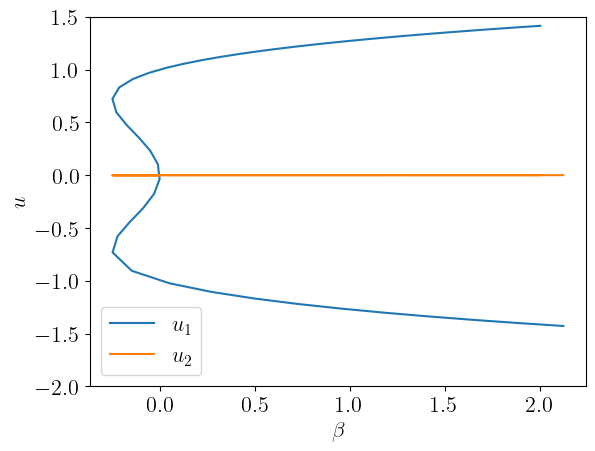

In [5]:
from scicomp.continuation import numerical_continuation
from scicomp.shooting import limit_cycle_shooting_func

hopf_res = numerical_continuation(equation=modified_hopf,
    variable_kwarg="beta", initial_value=2, y0=[1, 1, 6],
    step_size=-0.1, max_steps=47, discretisation=limit_cycle_shooting_func,
    discretisation_kwargs={
        "phase_condition": pc,
        "ivp_solver_kwargs": {"r_tol": 1e-6},
    })

fig, ax = plt.subplots()
ax.plot(hopf_res.parameter_values, hopf_res.state_values[0, :], label="$u_1$")
ax.plot(hopf_res.parameter_values, hopf_res.state_values[1, :], label="$u_2$")
ax.set(xlabel=r"$\beta$", ylabel="$u$", ylim=[-2, 1.5]); ax.legend();

To demonstrate tracking the equilibrium of an ODE, consider $\dot{x} = x^3 - x + c$, where $c$ is the parameter to vary.

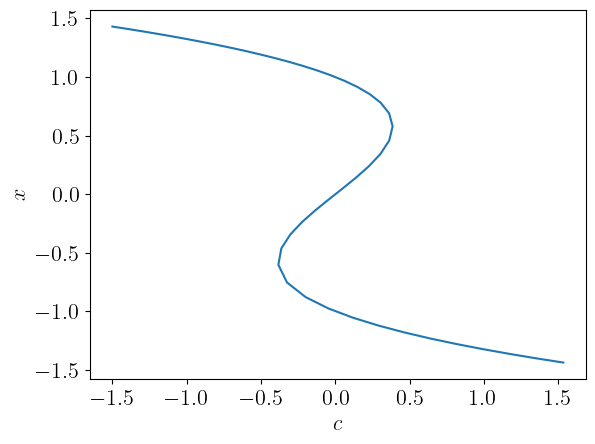

In [6]:
def equation(x, c):
    return x**3 - x + c

ode_res = numerical_continuation(equation, variable_kwarg="c", step_size=0.1,
                                 initial_value=-1.5, max_steps=45, y0=[1.5])

fig, ax = plt.subplots()
ax.plot(ode_res.parameter_values, ode_res.state_values[0, :])
ax.set(xlabel="$c$", ylabel="$x$");

## Boundary Value Problems

`scicomp` implements functions for the finite difference method, which can be used to solve boundary value problems.  Convenience functions for common BVPs are also provided. For example, consider the steady state Bratu problem

\begin{align}
D u_{xx} + e^{\mu u} = 0, \qquad u(0) = u(1) = 0,
\end{align}
when $D = 1.0$ and $\mu = 0.1$.

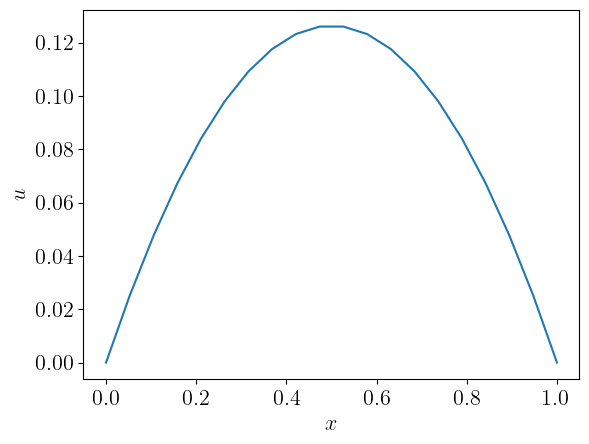

In [7]:
from scicomp.finite_diff import DirichletBC, Grid
from scicomp.bvps import solve_nonlinear_poisson_eq

D = 1
mu = 0.1

# define the boundary conditions
left_bc = right_bc = DirichletBC(0)

# define the domain
grid = Grid(a=0, b=1, N=20, left_BC=left_bc, right_BC=right_bc)

# solve using convenience function
bratu_sol = solve_nonlinear_poisson_eq(u0=np.ones_like(grid.x_inner), grid=grid, D=D,
                                       q=lambda u, x: np.exp(mu * u), sparse=True)

fig, ax = plt.subplots()
ax.plot(grid.x, bratu_sol)
ax.set(xlabel="$x$", ylabel="$u$");

For BVPs where there is not a pre-implemented convenience function, it is possible to solve the problem using the individual finite difference functions instead. As an example, consider the steady state reaction-convection-diffusion equation

\begin{equation}
D u_{xx} -vu_{x} + q(x) = 0,
\end{equation}

where $D=0.01$, $v=1$, $q(x)=1$ and $u(0)=u(1)=0$. The following shows how this would be solved using a central difference approximation for both derivatives and using sparse linear algebra.

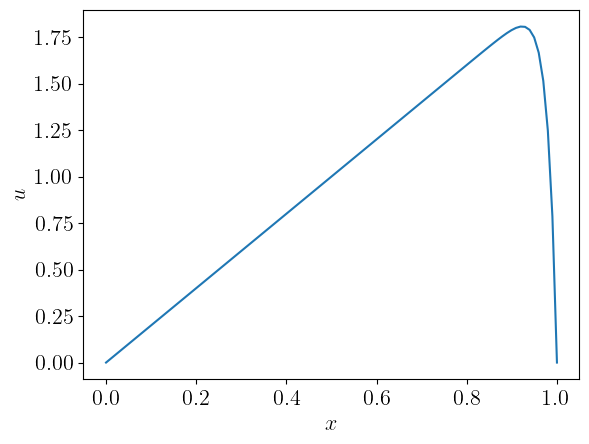

In [8]:
from scicomp.finite_diff import get_A_mat_from_BCs, apply_BCs_to_soln
from scipy.sparse.linalg import spsolve

# define the domain
grid = Grid(a=0, b=1, N=100, left_BC=left_bc, right_BC=right_bc)

D = 0.01
v = 1
q = np.ones_like(grid.x_inner)

A_1 = get_A_mat_from_BCs(2, grid=grid, sparse=True)
A_2 = get_A_mat_from_BCs(1, grid=grid, sparse=True)
# as BCs are zero no b vector is needed, normally created with: b = get_b_vec_from_BCs

sol = spsolve(D * A_1 - 0.5 * v * grid.dx * A_2, -grid.dx**2 * q)

fig, ax = plt.subplots()
ax.plot(grid.x, apply_BCs_to_soln(sol, grid=grid))
ax.set(xlabel="$x$", ylabel="$u$");

To see how the solution changes with $D$, we can use numerical continuation to track the maximum of the solution.

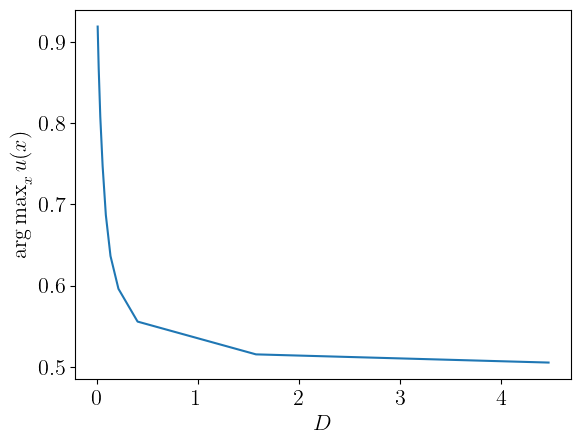

In [9]:
def react_convect_diff(u, D, v):
    return (D * A_1 - 0.5 * v * grid.dx * A_2)@u + grid.dx**2 * q

rcd_res = numerical_continuation(react_convect_diff, variable_kwarg="D",
                                 fixed_kwargs={"v":1}, initial_value=0.01,
                                 step_size=0.01, max_steps=10, y0=sol)

fig, ax = plt.subplots()
ax.plot(rcd_res.parameter_values, grid.x_inner[np.argmax(rcd_res.state_values, axis=0)])
ax.set(xlabel="$D$", ylabel=r"$\argmax_x u(x)$");

This shows that, as $D$ tends to zero, the peak of the solution moves to the right. 

## Partial Differential Equations

The first method of solving PDEs offered by `scicomp` is the method of lines. As a demonstration, consider the dynamic version of the Bratu problem

\begin{align}
u_t = D u_{xx} + e^{\mu u}, \qquad u(0,t) = u(1,t) = 0, \qquad u(x,0)=0,
\end{align}
where $D = 1.0$ and $\mu = 0.1$.

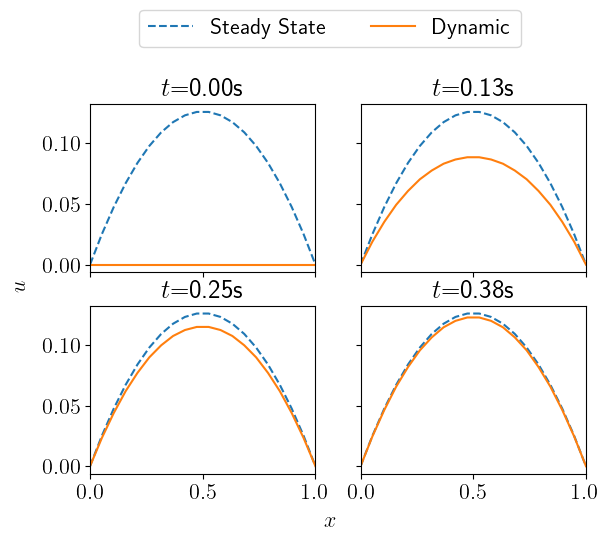

In [10]:
from scicomp.pdes import solve_diffusion_method_lines

D = 1
mu = 0.1

# define the boundary conditions
left_bc = right_bc = DirichletBC(0)

# define the domain
grid = Grid(a=0, b=1, N=20, left_BC=left_bc, right_BC=right_bc)

dynamic_bratu_sol = solve_diffusion_method_lines(grid=grid,D=D,
    u0_func=lambda x: np.zeros_like(x), sparse=True,
    q=lambda u, x, t: np.exp(mu * u), t_span=[0, 0.5])

fig, axs = plt.subplots(2, 2, sharey=True, sharex=True)

for i, ax in enumerate(axs.reshape(-1)):
    i = int(i * dynamic_bratu_sol.t.size // 4)
    ax.set_title(f"$t$={dynamic_bratu_sol.t[i]:.2f}s")
    ax.plot(grid.x, bratu_sol, "--", grid.x, dynamic_bratu_sol.u[i, :])

plt.setp(axs, xlim=[0, 1])
fig.legend(["Steady State", "Dynamic"], ncols=2, loc="upper center",
    bbox_to_anchor=(0.5, 1.1), bbox_transform=fig.transFigure)
fig.text(0.5, 0, '$x$', ha='center'); fig.text(0, 0.5, '$u$', va='center', rotation='vertical');

The same PDE can be solved using the Crank–Nicolson method. Here, whilst the main method is implicit, the nonlinear source term is treated explicitly.

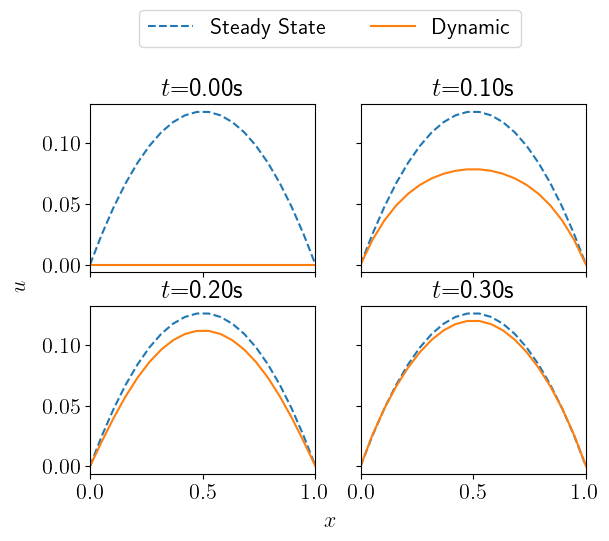

In [11]:
from scicomp.pdes import solve_diffusion_implicit

dynamic_bratu_sol = solve_diffusion_implicit(grid=grid,D=D,
    u0_func=lambda x: np.zeros_like(x), sparse=True,
    q=lambda u, x, t: np.exp(mu * u), dt=0.1, steps=4)

fig, axs = plt.subplots(2, 2, sharey=True, sharex=True)

for i, ax in enumerate(axs.reshape(-1)):
    i = int(i * dynamic_bratu_sol.t.size // 4)
    ax.set_title(f"$t$={dynamic_bratu_sol.t[i]:.2f}s")
    ax.plot(grid.x, bratu_sol, "--", grid.x, dynamic_bratu_sol.u[i, :])

plt.setp(axs, xlim=[0, 1])
fig.legend(["Steady State", "Dynamic"], ncols=2, loc="upper center",
    bbox_to_anchor=(0.5, 1.1), bbox_transform=fig.transFigure)
fig.text(0.5, 0, '$x$', ha='center'); fig.text(0, 0.5, '$u$', va='center', rotation='vertical');

# Design Decisions
The `scicomp` package is intended to be production-quality code. This means that all items of the public application programming interface (API) have full docstrings and most have a usage example. All docstrings have been written in the [numpydoc](https://numpydoc.readthedocs.io/en/latest/format.html) format. This means that if the package was to be published, documentation could automatically be generated using [Sphinx](https://www.sphinx-doc.org/en/master/). Furthermore, all items in the public API have unit tests to ensure that the code functions as expected and gives the same result as the analytical solution, where applicable. The final project has 98% test coverage. While this does not guarantee the code is free from bugs, it does mean that the vast majority of statements are executed during testing. This helps to prevent regressions and provides an extra form of documentation. The unit tests are automatically executed when new commits are pushed to GitHub using the GitHub Actions continuous integration (CI) platform. Furthermore, the examples given in docstrings are also checked using doctests as part of the CI job. Multiple versions of Python are used during the CI test run to ensure the code is compliant with the [NEP 29](https://numpy.org/neps/nep-0029-deprecation_policy.html) standard. There is an additional CI job that runs a linter to check compliance with the [PEP 8](https://peps.python.org/pep-0008/) style guide and detect common bad practises. Type hints are provided for all functions in accordance with [PEP 483](https://peps.python.org/pep-0483/). This was done to provide an additional form of documentation, help IDEs provide better suggestions, and catch errors relating to incorrect types. The correctness of these type hints is checked in a CI job using the static type checker Mypy.

The public API for the `scicomp` package has been designed to be easy to extend and maintain. For example, where functions are required to return multiple results, results objects are used instead of returning tuples. This means that, if new features are added in the future it is possible to add to the results object. Instead, if the function returned a longer tuple, this would be backwards incompatible and break users' existing code. Another example of this  design philosophy is making the options for most functions keyword-only arguments. This makes it more straightforward to modify the signature of a function in a backward-compatible manner. 

A common programming principle that was followed is "Don't repeat yourself" (DRY). This aims to reduce repetition by using abstraction. However, this added abstraction has the potential to pollute the API with functions, classes, and methods that are not designed for public consumption. Therefore, to designate this, objects that are named with a leading underscore are intended to be private, with everything else being part of the public API. An example of this is the `_error_norm` function, which is used throughout the IVP solver.

Another collection of patterns that were considered when designing the API for this package were the SOLID principles of object-oriented programming. The first SOLID principle is the single-responsibility principle, which states a class should only have one responsibility [3]. Examples of this influencing the design include the boundary condition class whose only responsibility is to represent the boundary condition and the phase condition classes whose only responsibility is to calculate the phase condition. The next principle is the open–closed principle, which states "software entities should be open for extension, but closed for modification" [4]. An example of this is the `_RungeKuttaStep` abstract base class where the concrete subtypes define the implementation and different implementations can be polymorphically substituted for each other. The third principle is the Liskov substitution principle, which states that every subtype should be substitutable for its parent type [5]. An example of this is the classes that represent the phase conditions. The fourth principle is the interface segregation principle, which states "no code should be forced to depend on methods it does not use" [3]. An instance of this is having different types of result objects for different types of numerical methods rather than one giant result object. The final principle is the dependency inversion principle which states "Depend upon abstractions, not on concretions" [3]. A case of this is the numerical shooting which only depends on the phase condition abstract base class rather than one of the concrete implementations such as the derivative phase condition.

The submodules and functions of `scicomp` are designed to be composable in order to create new functionality. An example of this is the numerical continuation function, which is composed of the shooting function, which in turn uses the IVP solver. This reduces code duplication and also allows the user to replace and extend components of the code base with code they have written. For example, it is possible to replace the IVP solver used in the shooting component with the solver from SciPy. This is useful as SciPy offers methods for solving stiff ODEs whereas `scicomp` does not.

Where possible, `scicomp` tries to use Numpy arrays, universal functions, and operator broadcasting to avoid for loops. This improves the performance as the for loop then occurs in a low-level language and operations can leverage the single instruction, multiple data (SIMD) instruction set. Furthermore, Numpy arrays use less memory than Python lists as they are stored as contiguous arrays, whereas a Python list is an array of pointers to other objects. Numpy arrays are stored in memory in row-major order by default. This means the rows of an array are contiguous in memory so it is faster to access a row of a Numpy array (as all elements are close in memory) than the columns. In situations where for loops are unavoidable (such as advancing the solution using Crank-Nicolson), they have been carefully designed to loop over the rows of the array so that they access a contiguous slice of memory, which improves the performance of the code.

When designing `scicomp.integrate.solve_ivp` it was decided to define all stepping methods in terms of their Butcher tableau rather than writing unique code for each method. The Butcher tableau is the following structure:
\begin{equation}
\begin{array}
{c|c}
\mathbf{c}& \mathbf{A}\\
\hline
& \mathbf{b}
\end{array}.
\end{equation}
This was decided as, for any explicit $s$ stage Runge-Kutta method, the solution can be advanced by one time step using the equation
\begin{equation}
y_{n+1} = y_{n} + h\sum_{i=1}^{s}b_ik_i,
\end{equation}
where
\begin{equation}
k_i = f(x_i + c_i h, y_i + h\sum_{j=1}^{i-1}a_{s,j}k_j) \ [1].
\end{equation}
This reduces code duplication and makes the package easy to extend, as the only requirement for adding a new method is to define the entries of the Butcher Tableau. This is done by creating a concrete subtype of the abstract base class `scicomp.integrate._RungeKuttaStep`. All methods can be used with an adaptive timestep. I decided to implement this as it is more efficient and robust than using a fixed timestep, as the solver can time larger steps when the error is high and smaller steps when the error is low. Furthermore, an adaptive timestep method is useful for the method of lines as, in general, it will handle the stability criterion automatically.

Some simplifications have been made to the IVP solvers compared to the solvers found in SciPy and MATLAB due to time constraints in producing this package. For example, `scicomp.integrate.solve_ivp` can only integrate forwards in time. This decision was made as this package is designed for studying dynamical systems, where typically only the solution forward in time is of interest.

Another simplification made is the form in which the solution is outputted. If the fixed timestep mode is used, the outputted solution is given at regular intervals. However, this is not the case if the adaptive timestep mode is used. This means that if the user requires the solution at specific times, they are forced to use the less efficient fixed timestep mode. An improvement would be to provide the option for a dense output that uses an interpolating polynomial to cheaply evaluate the solution at specified times. However, as shooting and continuation are mostly dependent on the final value of the solution as opposed to the intermediate values, it was decided not to implement a dense output.

The methods with embedded error estimates are designed such that function evaluations from the previous step can be reused in the next step. This property is called first same as last (FSAL). For example, the Dormand–Prince method can be calculated using six function evaluations per step despite having seven stages. This is useful if the right hand side function of the ODE is expensive to evaluate. However, as none of the ODEs used within this package are very complicated, for simplicity, `scicomp.integrate.solve_ivp` does not implement FSAL.

As methods for solving PDEs are not as general as those for solving IVPs, this required careful design to create a reusable set of components that could be combined to solve a range of PDE problems. In general, this starts by defining the boundary condition objects and then the `Grid` object, which defines the discretisation of the domain. The `get_A_mat_from_BCs` and `get_b_vec_from_BCs` automatically create the finite difference matrices and boundary condition vectors that are required for finite difference methods. This means the user does not have to worry about which elements need changing in the martix or vector for their given boundary condition. Common BVPs and PDEs have convenience functions defined in `scicomp.bvps` and `scicomp.pdes` respectively that automatically set up the problem for the user. This design was chosen as it abstracts away the need to worry about details, such as finite difference coefficients, from the user.

For solving Poisson's equation, there is both `scicomp.bvps.solve_linear_poisson_eq` for Poisson's equation with linear source terms and `scicomp.bvps.solve_nonlinear_poisson_eq` for nonlinear source terms. The linear version solves a linear system of equations, whereas the nonlinear version uses root finding. The reason for including both despite the fact that all linear source terms can also be solved using the nonlinear function is because solving linear systems is generally faster than root finding. We can confirm this using benchmarking.

In [12]:
from timeit import timeit

setup = """
import numpy as np
from scicomp.finite_diff import DirichletBC, Grid
from scicomp.bvps import solve_nonlinear_poisson_eq, solve_linear_poisson_eq
D=1
left_bc = DirichletBC(0)
right_bc = DirichletBC(10)
grid = Grid(a=0, b=1, N=1000, left_BC=left_bc, right_BC=right_bc)
"""

nonlin = """
solve_nonlinear_poisson_eq(u0=np.linspace(0, 10, num=grid.N_inner), grid=grid, D=D, q=lambda u, x: np.ones_like(x), sparse=True)
"""
lin = """
solve_linear_poisson_eq(grid=grid, D=D, q=lambda x: np.ones_like(x), sparse=True)
"""

linear_solve_time = timeit(stmt=lin, setup=setup, number=10)
nonlinear_solve_time = timeit(stmt=nonlin, setup=setup, number=10)
print(f"{linear_solve_time=}, {nonlinear_solve_time=}")

linear_solve_time=0.006720744997437578, nonlinear_solve_time=17.06614442400314


Here we see that `solve_linear_poisson_eq` is over one thousand times faster for the same problem. We can confirm that root-finding is where the majority of the execution time is spent in `solve_nonlinear_poisson_eq` using profiling.

In [13]:
import cProfile, pstats

exec(setup)
pr = cProfile.Profile(builtins=False)
pr.run(nonlin)
pstats.Stats(pr).strip_dirs().sort_stats("tottime").print_stats(5);

         44451 function calls in 1.709 seconds

   Ordered by: internal time
   List reduced from 144 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    1.677    1.677    1.708    1.708 _minpack_py.py:184(_root_hybr)
     2006    0.008    0.000    0.031    0.000 bvps.py:134(eq)
     2006    0.007    0.000    0.008    0.000 _compressed.py:480(_mul_vector)
     2010    0.002    0.000    0.002    0.000 <__array_function__ internals>:177(copyto)
     2009    0.002    0.000    0.002    0.000 <__array_function__ internals>:177(empty_like)




As expected, we can see that the majority of time is spent in `_minpack_py.py` which is part of the SciPy root-finding function. The performance of the `solve_linear_poisson_eq` function when `sparse=False` could be further increased by exploiting the tridiagonal structure of the linear system. Currently, it uses `scipy.linalg.solve` to solve the system, which in turn uses the `dgesv` LAPACK routine to solve the system using LU factorisation with partial pivoting. Instead, as the system is tridiagonal, either Thomas' algorithm or the `dgtsv` LAPACK routine, which is designed specifically for tridiagonal systems, could be used to improve performance.

All PDE methods have the option to use either dense or sparse linear algebra through the use of the `sparse` keyword argument. For large systems, sparse linear algebra offers better performance and a reduced memory footprint as the finite difference matrices are sparse in nature. The option to use dense linear algebra is provided as it is easier to debug with dense arrays, as the entries of the matrices can be read directly.

# Reflective Learning Log

In past units, such as Numerical Methods in MATLAB, I had been introduced to and implemented Runge-Kutta methods for solving IVPs. However, these implementations always used a fixed time step. This often results in wasted computation as the same time step is used even when the ODE is easy to integrate. During this coursework, I have implemented an adaptive step size algorithm for the first time, both using Richardson extrapolation and an embedded error estimate. This has given me a better understanding of how functions such as SciPy's `solve_ivp` or MATLAB's `ODE45` work, which will be useful in the future for debugging a failed solve. In implementing an adaptive time step, I became familiar with reference literature such as Hairer and Wanner [1] and Butcher [2]. This has broadened my understanding of numerical methods for solving ODEs. For example, I was previously not familiar with the initial step size selection algorithm that I implemented.

During this project, I have also developed an appreciation for what is required to develop robust numerical code. For example, when I first implemented the adaptive step size solver, it functioned as expected in most cases. However, it had division by zero issues in the edge case where the initial conditions or the RHS function were zero. To fix this, I had to add extra checks to my code. From this, I learned a valuable lesson: often, theoretical descriptions of numerical algorithms in the literature may require additional checks and error handling to deal with edge cases that may occur during real-world use.

This project was the first time I configured GitHub Actions from scratch. While I have previously used the Gitlab and Azure CI platforms, learning the specific configurations for GitHub Actions is especially useful due to the free minutes offered. This means it will be possible to use Github Actions to automate the execution of my unit tests on future projects for free. Furthermore, starting the project from scratch gave me full control over the toolchain used. This allowed me to experiment with new tools such as Ruff, the linter I used.

Developing many of the functions for my package was a two-stage process. First, I had to figure out how to implement the numerical algorithm. Then, I had to figure out how to integrate it with the rest of the functionality in the package. Especially for functions with complex interfaces, such as the numerical continuation function, trying to do these two steps simultaneously was challenging. Instead, I found it easier to first create a rough implementation of the numerical algorithm without worrying about abstraction, code duplication, or other best practises. Once I was happy with how the method worked, I would then iterate on this prototype to develop the final API. I found this an easier way of working, as until you understand the method, it is difficult to decide how you want the user to interact with it. This workflow will help me be efficient when implementing new numerical algorithms in the future.

In the short term, I intend to use what I have learned in this unit during my MDM projects, as they often involve collaborative aspects. This puts an emphasis on the need to have clear and concise code as multiple people have to work with the code base. Further, MDM results are often based on numerical simulations, so ensuring code correctness is essential to avoid spurious results. Hence, unit testing and continuous integration, as used in this project, will be very useful. Longer term, I envisage the best practises learned in this unit being useful while working on my master's thesis. I also hope to use some of the skills I have learned to contribute to open-source software.

If I were doing this project again, the thing I would do differently would be to define the requirements of a given functionality before starting to write code. This is because, without a clear set of requirements, it was easy to spend a lot of time adding new features that were not strictly necessary to progress to the next stage of the project. This occurred when I was writing my IVP solver, as I tried to add lots of features such as adaptive time-stepping and initial step size estimation. However, these features took a long time to implement and were not necessary to start work on numerical shooting. Implementing them regardless of this meant I was behind schedule when it came to implementing numerical shooting and continuation in the workshops.

# Conclusion

This report has demonstrated the range of functionality offered by the `scicomp` package, such as being able to track the periodic orbits of the modified normal form of the Hopf bifurcation and solving the Bratu problem. Design decisions, such as defining all Runge Kutta methods in terms of their Butcher tableau, and reflections on the project have also been discussed.

# References

[1] Hairer, E. and Wanner, G. (1991) Solving Ordinary Differential Equations II: Stiff and Differential-Algebraic Problems. Springer, Berlin.
http://dx.doi.org/10.1007/978-3-662-09947-6

[2] Butcher, J.C. (2008) Numerical Methods for Ordinary Differential Equations. 2nd Edition, John Wiley & Sons, Ltd., Chichester.
http://dx.doi.org/10.1002/9780470753767

[3] Martin, R. (2002). Agile Software Development: Principles, Patterns, and Practices. Pearson Education.

[4] Meyer, B. (1988). Object-Oriented Software Construction. Prentice Hall.

[5] Liskov, B. and Wing, J. (1994). "A behavioral notion of subtyping". ACM Transactions on Programming Languages and Systems